In [170]:
'''
Import Necessary Libraries
'''
import tensorflow as tf
# from tensorflow.keras.optimizers import Adam
# If the warning persists, you might try using the legacy optimizer as follows:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Input, Concatenate, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers, models # for defining the generator and discriminator networks
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for data visualization
from PIL import Image # for loading images
import matplotlib.image as mpimg # for loading images
import matplotlib.pyplot as plt
import pandas as pd # for data visualization
import sklearn # for any additional machine learning utilities
from sklearn.preprocessing import MultiLabelBinarizer # for one-hot encoding of ingredient labels
from sklearn.model_selection import train_test_split # for splitting the dataset
import skimage # for image processing
from skimage.transform import resize
from skimage.io import imread
import os

# print("TensorFlow version:", tf.__version__)

### Loading the Dataset
- Loading the JSON file ('smoothies.json') into a pandas DataFrame named 'dataset', where each row corresponds to a smoothie, with columns for 'image' and 'ingredients'.
- Pandas reads the JSON file.
- The 'image' column contains the path to the image file, and 'ingredients' is a list of ingredients for each smoothie.

In [171]:
'''
Load the Dataset
'''
# Define the path to your JSON file
# dataset_path = 'datasets/smoothies.json'
file_path = '/Users/brandiellenkinard/Documents/000-smoothie-ingredients/myproject/smoothie-cGAN/datasets/datasets/smoothies.json'

# Load the dataset
dataset = pd.read_json(file_path)

# Display the first few rows of the dataframe to verify it's loaded correctly
# print(dataset.head())

### Preprocessing Images
- Images should be resized to a consistent size (e.g. 128x128 pixels).
- Resizing and normalizing images using the 'skimage' library.

`preprocess_image` function code block

```python
def preprocess_image(image_path, target_size=(128, 128)):
    image = imread(image_path)
    image_resized = resize(image, target_size, anti_aliasing=True)
    return image_resized

# Example usage
# Since the image is not in the same directory (folder) as the notebook, go up one directory level from 'notebooks' to 'myproject' and then down into the 'datasets' directory to find this image.
example_image_path = '../datasets/redBerryAndBeetSmoothie.png'  # Adjusted path
# plt.imshow(example_image)
example_image = preprocess_image(example_image_path)
plt.imshow(example_image)
plt.show()
```
---
Apparently, my image path is not working so I'm pasting this here and replacing it with an another version where the path is adjusted (since the images are not in the 'notebooks' directory (current working directory) but rather one level up and then within the 'datasets' directory):
```python
'''
Preprocessing Images
'''

# Normalization helps the model learn more efficiently. This is important for neural network training, because it helps with the convergence of the model.
# Pixel values range from 0 to 255, so dividing by 255 will scale them to the [0,1] range, which is common and works well for most models.
def preprocess_image(image_path, target_size=(128, 128)):
    with Image.open(image_path) as img:
        img = img.convert('RGBA')  # Ensure image is in RGBA format
        canvas = Image.new('RGBA', img.size, (255,255,255,255))  # Create a white canvas
        canvas.paste(img, mask=img)  # Paste the image onto the canvas
        img = canvas.convert('RGB')  # Convert back to RGB
        img = img.resize(target_size)
        img = np.array(img) / 255.0
    return img
```
---
Apparently, this doesn't work either (my split the dataset code cell doesn't like it for some reason):
```python
'''
Preprocessing Images
'''

# Normalization helps the model learn more efficiently. This is important for neural network training, because it helps with the convergence of the model.
# Pixel values range from 0 to 255, so dividing by 255 will scale them to the [0,1] range, which is common and works well for most models.
def preprocess_image(image_path, target_size=(128, 128)):
    # Construct the full path to the image, going up one level from 'notebooks' and then into 'datasets'
    full_image_path = os.path.join('..', image_path)
        
    with Image.open(image_path) as img:
        img = img.convert('RGBA')  # Ensure image is in RGBA format
        canvas = Image.new('RGBA', img.size, (255,255,255,255))  # Create a white canvas
        canvas.paste(img, mask=img)  # Paste the image onto the canvas
        img = canvas.convert('RGB')  # Convert back to RGB
        img = img.resize(target_size)
        img = np.array(img) / 255.0
    return img
```
---
Given that the error messages show the path as '.../datasets/datasets/...' in the output of my `Split the Dataset` cell, it seems there may be a redundant 'datasets' in the constructed path. This could be happening because the path is being joined twice, once when updating the `dataset['image']` paths and again inside the `preprocess_image` function. To fix this, I replaced the following function:
```python
'''
Preprocessing Images
'''

# Normalization helps the model learn more efficiently. This is important for neural network training, because it helps with the convergence of the model.
# Pixel values range from 0 to 255, so dividing by 255 will scale them to the [0,1] range, which is common and works well for most models.
def preprocess_image(image_path, target_size=(128, 128)):
    # Ensure the full path is correctly constructed from the notebook's location
    full_image_path = os.path.abspath(image_path)
    try:
        with Image.open(full_image_path) as img:
            img = img.convert('RGBA')  # Convert to RGBA to handle transparency
            canvas = Image.new('RGBA', img.size, "WHITE")  # Create a white canvas
            canvas.paste(img, mask=img.split()[3])  # Paste using alpha channel as mask
            img = canvas.convert('RGB')  # Convert back to RGB
            img = img.resize(target_size)
            img = np.array(img) / 255.0  # Normalize pixel values
        return img
    except IOError:
        print(f"Error opening or processing image {full_image_path}")
        return None
```
**I've condensed this cell down by A LOT, because it was too long. See my documentation for the full write-up.**

In [172]:
'''
Preprocessing Images
'''

# Normalization helps the model learn more efficiently. This is important for neural network training, because it helps with the convergence of the model.
# Pixel values range from 0 to 255, so dividing by 255 will scale them to the [0,1] range, which is common and works well for most models.
def preprocess_image(image_path, target_size=(128, 128)):
    # Ensure the full path is correctly constructed from the notebook's location
    full_image_path = os.path.abspath(image_path)
    try:
        with Image.open(full_image_path) as img:
            # Rest of your preprocessing code here
            img = img.convert('RGBA')  # Convert to RGBA to handle transparency
            canvas = Image.new('RGBA', img.size, "WHITE")  # Create a white canvas
            canvas.paste(img, mask=img.split()[3])  # Paste using alpha channel as mask
            img = canvas.convert('RGB')  # Convert back to RGB
            img = img.resize(target_size)
            img = np.array(img) / 255.0  # Normalize pixel values
        return img
    except IOError as e:
        print(f"Error opening or processing image {full_image_path}: {e}")
        return None

# Correctly update image paths relative to the notebook's current directory
dataset['image'] = dataset['image'].apply(lambda x: os.path.join('..', 'datasets', x))

# Preprocess images and convert them into an array X
# Ensure that only existing paths are passed to the preprocessing function
X = np.array(dataset['image'].apply(preprocess_image).tolist())

# After preprocessing images
image_shape = (128, 128, 3)  # Replace with the actual dimensions of your preprocessed images


### Visulizing a batch of preprocessed images to confirm they're ready for training

Error opening or processing image /Users/brandiellenkinard/Documents/000-smoothie-ingredients/myproject/datasets/datasets/avocolada.png: [Errno 2] No such file or directory: '/Users/brandiellenkinard/Documents/000-smoothie-ingredients/myproject/datasets/datasets/avocolada.png'


AttributeError: 'NoneType' object has no attribute 'shape'

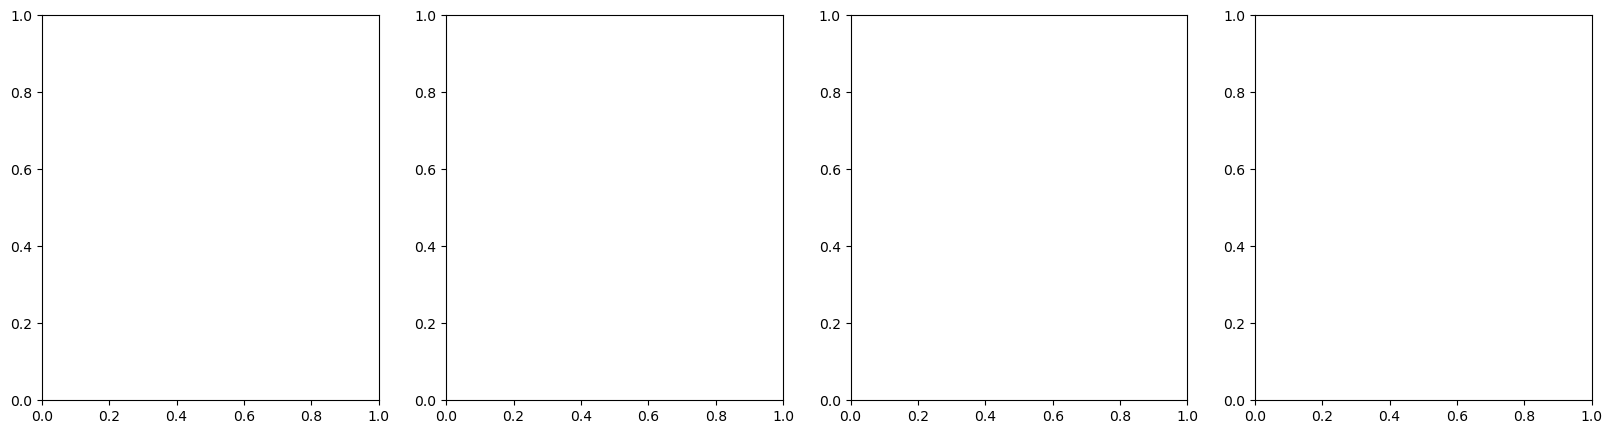

In [173]:
'''
Visualization
'''
# Assuming you have a function to preprocess and load images
# Display a few preprocessed images
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axs.flat):
    # The following line of code could not find my image...
    # img = preprocess_image(dataset['image'][i])
    # ...so I added the next two lines, ddjusting the path
    # 'os.path.join('..', dataset['image'][i])' is used to construct the path by going up one directory from the notebook's current directory and then down into the 'datasets' directory where the images are stored.
    image_path = os.path.join('..', dataset['image'][i])  # The 'datasets' folder is one level up from the notebook
    img = preprocess_image(image_path)

    # Print out the shape of each image to confirm it's being loaded
    print(f"Image {i} shape:", img.shape)
    # Check data type: ensure the image data is floating-point
    print("Data type:", img.dtype)
    # Check image values: ensure the values are within teh expected range after normalization
    print("Min and Max pixel values:", img.min(), img.max())

    # Show the image only if it's loaded correctly
    if img is not None and img.any():
        ax.imshow(img)
        ax.axis('off')
    else:
        print(f"Failed to load image at: {image_path}")

    # Trying something, so the next two lines will be commented out for now
    # ax.imshow(img)
    # ax.axis('off')
plt.show()

# Test loading and displaying one image directly without any preprocessing to ensure the images themselves are valid and not corrupted
test_img_path = os.path.join('..', 'datasets', 'avocolada.png')  # Adjust the path as needed
test_img = imread(test_img_path)
plt.imshow(test_img)
plt.axis('off')
plt.show()

## Encode Ingredient Labels
- For simplicity and given the scope of this project, I've considered encoding the ingredient labels using one-hot encoding (for now).
- I may transition to embeddings as I refine my model.

In [174]:
'''
Encode Ingredient Labels
'''
# Create a list of unique ingredients
unique_ingredients = set(item for sublist in dataset['ingredients'] for item in sublist)

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=sorted(unique_ingredients))

# Encode ingredient labels
ingredients_encoded = mlb.fit_transform(dataset['ingredients'])

# Now `ingredients_encoded` is a NumPy array where each row is a one-hot encoded vector of ingredients for a recipe.
# Optionally, show the shape or a sample of the encoded labels to verify
print("Shape of encoded labels:", ingredients_encoded.shape)

# After encoding ingredient labels
num_tags = ingredients_encoded.shape[1]  # Number of unique tags

Shape of encoded labels: (86, 89)


### Prepare Conditional Inputs
- Using the encoded labels (from the previous code cell) to prepare the conditional inputs for both the generator and discriminator.
- Expanding the ingredient tags for the generator:
    - For each training example, concentrate the ingredient tags (encoded as one-hot) with the noise vector that feeds into the generator.
- Prepare real images with tags for the discriminator:
    - Similarily, when feeding real images to the discriminator, combine them with the corresponding ingredient tags.
---
Modified 'generate_noise' function. This is just the old (keeping it for keepsake)

```python
'''
Prepare Conditional Inputs
'''
def generate_noise(batch_size, z_dim, num_tags, tags_encoded):
    noise = np.random.normal(0, 1, size=(batch_size, z_dim))
    tag_vectors = np.random.choice(tags_encoded, size=(batch_size,))
    combined_input = np.concatenate([noise, tag_vectors], axis=1)
```

---
Modified 'generate_noise' function again:
```python
def generate_noise(batch_size, z_dim, num_tags, tags_encoded):
    noise = np.random.normal(0, 1, size=(batch_size, z_dim))
    # Generate random indices to select tag vectors for each item in the batch
    indices = np.random.randint(low=0, high=tags_encoded.shape[0], size=batch_size)
    # Select the tag vectors using the generated indices
    tag_vectors = tags_encoded[indices]
    # Concatenate the noise and tag vectors
    combined_input = np.concatenate([noise, tag_vectors], axis=1)
    return combined_input
```

In [175]:
'''
Prepare Conditional Inputs
'''
def generate_noise(batch_size, z_dim):
    noise = np.random.normal(0, 1, size=(batch_size, z_dim))
    return noise

def combine_images_tags(images, tags_encoded):
    # Assuming `images` is a batch of preprocessed images
    # and `tags_encoded` is the corresponding one-hot encoded tags for the batch
    combined_input = [images, tags_encoded]
    return combined_input

### Split the Dataset
- Splitting the dataset into training and validation (testing) sets.

This is what I had before, but the image path could not be found:
```python
'''
Split the Dataset
'''
# Preprocess images and load them into an array X
X = np.array(dataset['image'].apply(lambda x: preprocess_image(x)).tolist())  # Preprocess and load images
# 'ingredients_encoded' is the array of encoded labels from the previous cell
y = ingredients_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
```
---
The following seems correct, however, my notebook doesn't seem to like it:
```python
'''
Split the Dataset
'''
# Update the image paths in the dataset to include the correct relative path
dataset['image'] = dataset['image'].apply(lambda x: os.path.join('..', 'datasets', x))

# Preprocess images and load them into an array X
X = np.array(dataset['image'].apply(lambda x: preprocess_image(x)).tolist())  # Preprocess and load images
# 'ingredients_encoded' is the array of encoded labels from the previous cell
y = ingredients_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
```

In [176]:
'''
Split the Dataset
'''
# Correctly update image paths relative to the notebook's current directory
dataset['image'] = dataset['image'].apply(lambda x: os.path.join('..', 'datasets', x))

# Preprocess images and convert them into an array X
X = np.array(dataset['image'].apply(lambda x: preprocess_image(x)).tolist())

# 'ingredients_encoded' contains the encoded labels
y = ingredients_encoded

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### Create Training Batches
- Create training and validation datasets using TensorFlow's 'tf.data' API.

Another way to write the code:
```python
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(tf.data.AUTOTUNE)
```

In [177]:
'''
Create Training Batches
'''
def create_dataset(X, y, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val, shuffle=False)

### Define the Generator
- The generator's goal is to create images that look like smoothies based on the input ingredient tags and noise vector.
- z_dim: Dimension of the noise vector.
- num_tags: Number of unique ingredient tags, one-hot encoding.


In [178]:
'''
Define the Generator
'''
# z_dim: Dimension of the noise vector.
# num_tags: Number of unique ingredient tags, one-hot encoding.

# Define the size of the noise vector
z_dim = 100  # Or any other size you've chosen for your project

def build_generator(z_dim, num_tags):
    model = models.Sequential()

    # Foundation for 128x128 image
    model.add(layers.Dense(128 * 32 * 32, input_dim=z_dim + num_tags))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((32, 32, 128)))

    # Upsample to 64x64
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsample to 128x128
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Output layer with tanh activation
    model.add(layers.Conv2D(3, (7,7), activation='tanh', padding='same'))
    return model

# Instantiate the generator
generator = build_generator(z_dim, num_tags)

### Define the Discriminator
- The discriminator's goal is to distinguish between real images from the dataset and fake images produced by the generator.
- image_shape: Dimensions of the input images.
- num_tags: Number of unique ingredient tags.

In [179]:
'''
Define the Discriminator
'''
# image_shape: Dimensions of the input images.
# num_tags: Number of unique ingredient tags.
def build_discriminator(image_shape, num_tags):
    image_input = layers.Input(shape=image_shape)
    tags_input = layers.Input(shape=(num_tags,))

    # Downsample
    x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(image_input)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Downsample to 32x32
    x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Flatten and concatenate tags
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, tags_input])

    # Output layer
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model([image_input, tags_input], x)
    return model

# Instantiate the discriminator
discriminator = build_discriminator(image_shape, num_tags)
# Compile the discriminator
discriminator.compile(optimizer=discriminator_optimizer, loss=loss_function)


### Define Loss Functions and Optimizers (Training Loop Adjustments)
- Before starting the training loop, both the generator and discriminator are defined with their conditional mechanisms in place.
- Define the loss functions and optimizers for both the generator and discriminator.

- This code sets up the binary cross-entropy loss function, which is common for GANs, and the Adam optimizer with a specific learning rate and beta_1 parameter. It compiles the discriminator with its optimizer and loss, and then it sets up a combined model. The combined model is used to train the generator to fool the discriminator.

(Note that before setting up the combined model, the discriminator's trainable parameter is set to False to ensure that its weights are not updated during the generator's training.)

(Note: Make sure to adjust the z_dim, num_tags, and any other hyperparameters to fit your specific model's architecture and problem statement.)

In [188]:
'''
Define Loss Functions and Optimizers (Training Loop Adjustments)
'''
# Define loss function
# loss_function = BinaryCrossentropy(from_logits=True)
loss_function = BinaryCrossentropy(from_logits=False)

# Optimizers for the discriminator and generator
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Instantiate and compile the discriminator
# Assuming 'image_shape' and 'num_tags' are defined earlier in your notebook
discriminator = build_discriminator(image_shape, num_tags)
# Compile the discriminator
discriminator.compile(optimizer=discriminator_optimizer, loss=loss_function)

# For the combined model we will only train the generator
discriminator.trainable = False

# Define the combined model with separate inputs for noise and tags
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model

# Assuming 'z_dim' and 'num_tags' are correctly defined
noise_input = Input(shape=(z_dim,))
tags_input = Input(shape=(num_tags,))

# Correctly concatenate noise and tags before feeding them to the generator
combined_input_for_generator = Concatenate()([noise_input, tags_input])

# Generate an image from the combined noise and tags
generated_image = generator(combined_input_for_generator)

# The discriminator takes the generated image and the original tags to determine validity
validity = discriminator([generated_image, tags_input])

# Define and compile the combined model
combined_model = Model(inputs=[noise_input, tags_input], outputs=validity)
combined_model.compile(optimizer=generator_optimizer, loss=loss_function)


### Configuration/Setup
- Define various hyperparameters (e.g. the batch size, the dimensionality of the noise vector (z_dim), the number of unique tags (num_tags), and the number of epochs).
- This keeps your notebook organized and makes it easier to adjust these parameters in one place.

In [189]:
'''
Configuration/Setup
'''
# Set the number of epochs for training
epochs = 5

# Set the batch size
batch_size = 32

# Set the dimensionality of the noise vector
# z_dim = 100

# Assuming num_tags has been defined earlier, based on the dataset
# num_tags = len(unique_tags)  # Example placeholder code

# Set the interval for saving images and models
save_interval = 1  # Save images and models after every 'save_interval' epochs

### Utility Functions
- This function should randomly select a subset of images and their corresponding tags from your dataset, matching the specified `batch_size`.

In [190]:
def get_batch(X, y, batch_size):
    """
    Selects a batch of items randomly from the dataset.

    Parameters:
    - X: numpy array of training data (images).
    - y: numpy array of labels (tags).
    - batch_size: integer, size of the batch to return.

    Returns:
    - A tuple (batch of images, batch of labels).
    """
    idx = np.random.randint(0, X.shape[0], batch_size)
    batch_images = X[idx]
    batch_tags = y[idx]
    return batch_images, batch_tags


### Training Loop
- Perform the actual training iterations (epochs) of the model.
- Implement the logic that alternatives between training the discriminator and the generator.
- This will involve feeding in the real and fake data along with the conditional inputs and using the loss function and optimizers to update the weights of the networks.
- The training loop will need to handle the conditional inputs (from the "Preparing Conditional Inputs" cell) correctly. The following code is a simplified version of what the training step might look like, focusing on the conditional aspect.
---
Old code (it works but it doesn't track loss or show generated images):
```python
'''
Training Loop
'''
for epoch in range(epochs):
    # Generate noise for the batch
    noise = generate_noise(batch_size, z_dim)
    
    # Randomly select tags for the fake images in the batch
    indices = np.random.randint(0, ingredients_encoded.shape[0], batch_size)
    fake_tags = ingredients_encoded[indices]

    # Concatenate noise and tags to match the generator's input expectation
    generator_input = np.concatenate([noise, fake_tags], axis=1)

    # Generate fake images using the concatenated input
    fake_images = generator.predict(generator_input)

```

1/1 [==============================] - 1s 565ms/step


2024-02-23 03:12:55.114421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:12:55.341480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:12:55.442548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	

1/1 [==============================] - 1s 543ms/step


2024-02-23 03:12:58.662460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:12:58.775764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:12:58.887034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	

Epoch 1/5, Discriminator Loss: 0.8120220005512238, Generator Loss: 0.5003864467144012
1/1 [==============================] - 1s 514ms/step


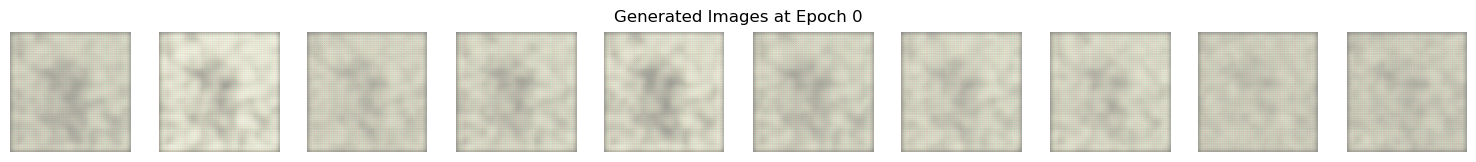

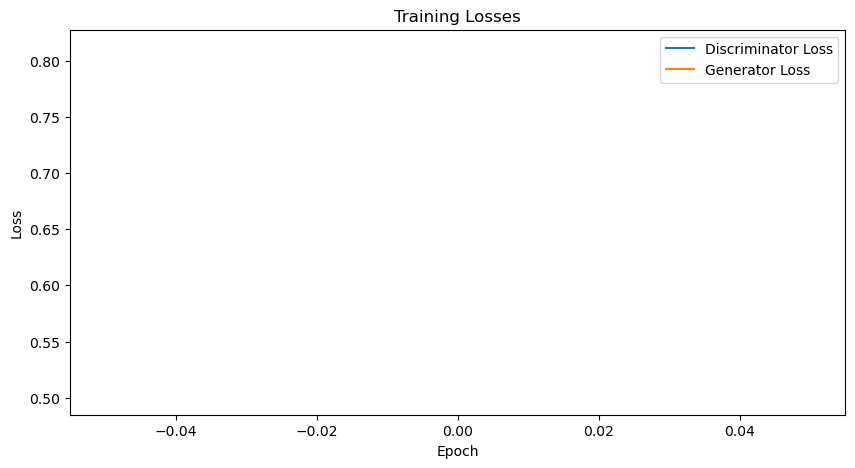

1/1 [==============================] - 1s 509ms/step


2024-02-23 03:13:02.610290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:02.717387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:02.824587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	

1/1 [==============================] - 1s 535ms/step


2024-02-23 03:13:05.612696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:05.727210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:05.836255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	

Epoch 2/5, Discriminator Loss: 0.6932895481586456, Generator Loss: 0.6463055610656738
1/1 [==============================] - 0s 496ms/step


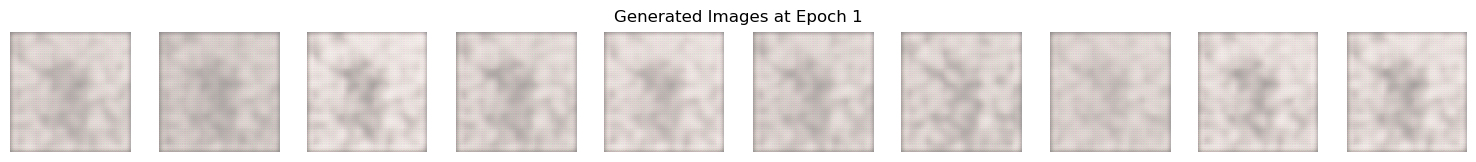

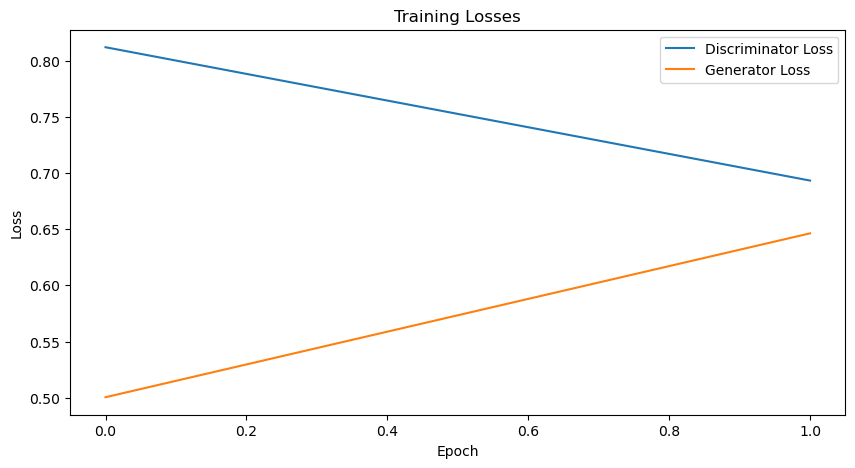

1/1 [==============================] - 1s 562ms/step


2024-02-23 03:13:09.264782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:09.374097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:09.485561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	

1/1 [==============================] - 1s 543ms/step


2024-02-23 03:13:12.193068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:12.301827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:12.415825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	

Epoch 3/5, Discriminator Loss: 0.7054589986801147, Generator Loss: 0.7084788680076599
1/1 [==============================] - 1s 534ms/step


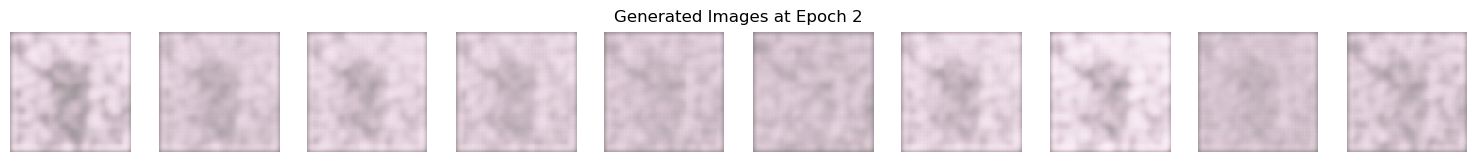

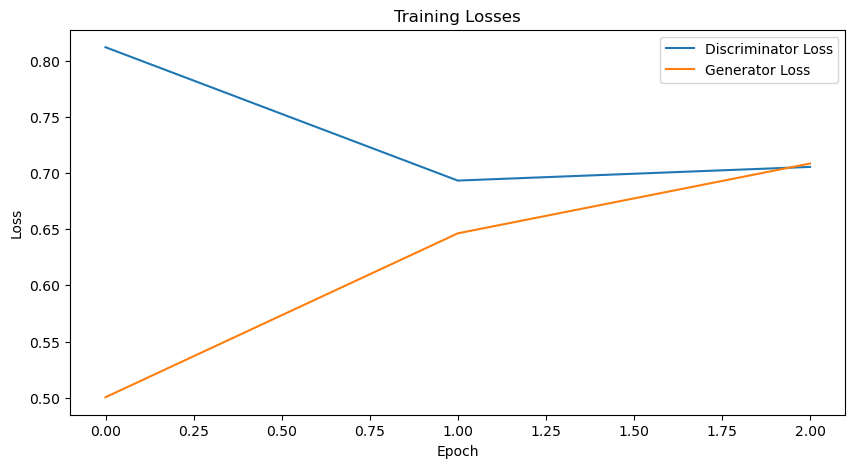

1/1 [==============================] - 1s 535ms/step


2024-02-23 03:13:15.918126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:16.023794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:16.130568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	

1/1 [==============================] - 1s 536ms/step


2024-02-23 03:13:18.828879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:18.941030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:19.052906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	

Epoch 4/5, Discriminator Loss: 0.6848680078983307, Generator Loss: 0.736801266670227
1/1 [==============================] - 1s 513ms/step


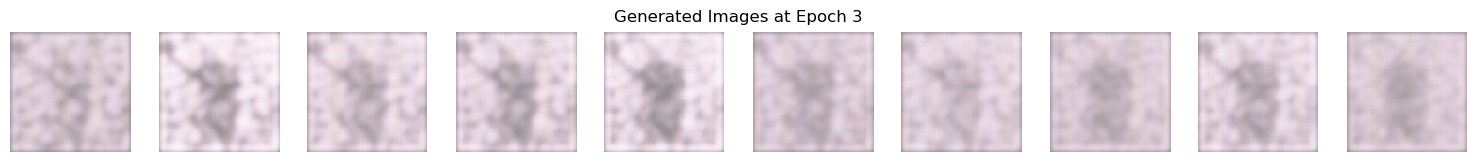

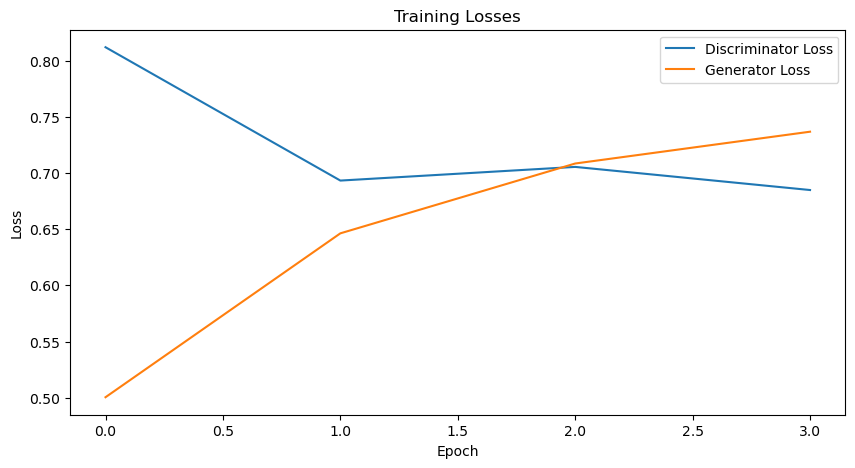

1/1 [==============================] - 1s 550ms/step


2024-02-23 03:13:22.611010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:22.730828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:22.838111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	

1/1 [==============================] - 1s 529ms/step


2024-02-23 03:13:25.482372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:25.595120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	 [[{{node Placeholder/_2}}]]
2024-02-23 03:13:25.704964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [32,1]
	

Epoch 5/5, Discriminator Loss: 0.6471288949251175, Generator Loss: 0.7645837962627411
1/1 [==============================] - 1s 523ms/step


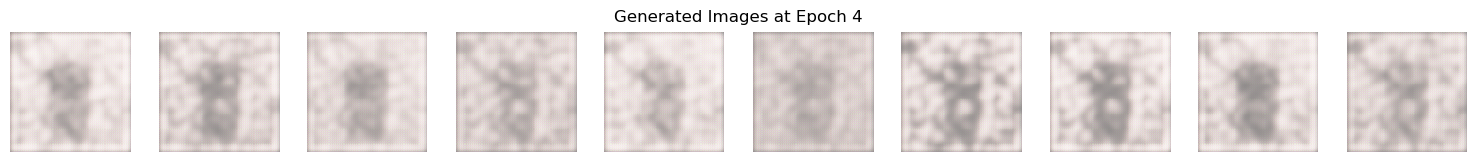

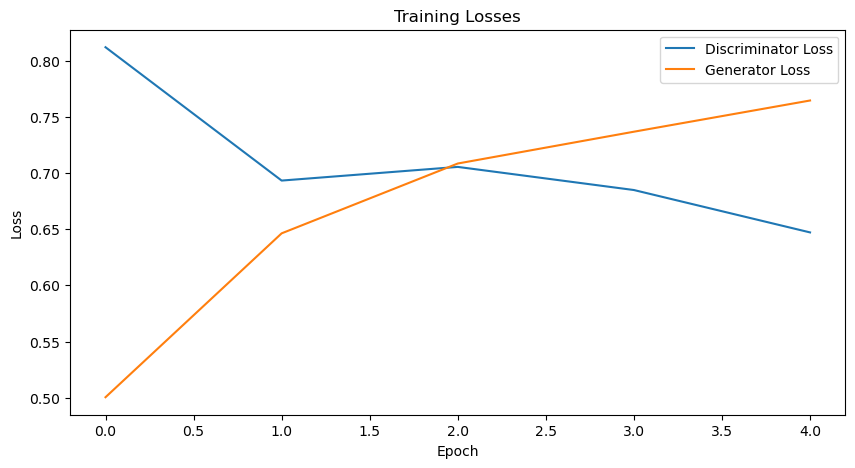

In [191]:
'''
Training Loop
'''
# Lists to keep track of loss
discriminator_losses = []
generator_losses = []

# Function to display generated images
def show_generated_images(epoch, generator, generator_input, examples=10, dim=(1, 10), figsize=(15, 1.5)):
    # Predict (generate) images from the input
    generated_images = generator.predict(generator_input)
    generated_images = (generated_images + 1) / 2.0  # scale from [-1,1] to [0,1] if using tanh activation
    # Display the generated images
    plt.figure(figsize=figsize)
    for i in range(examples):  # limit the loop to the 'examples' value
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(f'Generated Images at Epoch {epoch}', y=1.05)
    plt.show()


# Training Loop
for epoch in range(epochs):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    num_batches = int(X_train.shape[0] / batch_size)
    
    for index in range(num_batches):
        # Generate noise for the batch
        noise = generate_noise(batch_size, z_dim)
        # Randomly select tags for the fake images in the batch
        indices = np.random.randint(0, ingredients_encoded.shape[0], batch_size)
        fake_tags = ingredients_encoded[indices]

        # Concatenate noise and tags to match the generator's input expectation
        generator_input = np.concatenate([noise, fake_tags], axis=1)

        # Generate fake images using the concatenated input
        fake_images = generator.predict(generator_input)

        # Generate fake images
        # fake_images = generator.predict([noise, fake_tags])

        # Get a batch of real images and their corresponding tags
        real_images, real_tags = get_batch(X_train, y_train, batch_size)

        # Labels for real and fake data
        label_real = np.ones((batch_size, 1))
        label_fake = np.zeros((batch_size, 1))

        # Train the discriminator on real and fake data
        d_loss_real = discriminator.train_on_batch([real_images, real_tags], label_real)
        d_loss_fake = discriminator.train_on_batch([fake_images, fake_tags], label_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        epoch_d_loss += d_loss

        # Train the generator
        g_loss = combined_model.train_on_batch([noise, fake_tags], label_real)
        epoch_g_loss += g_loss

    # Store the losses
    discriminator_losses.append(epoch_d_loss / num_batches)
    generator_losses.append(epoch_g_loss / num_batches)

    # Display the progress
    print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {epoch_d_loss/num_batches}, Generator Loss: {epoch_g_loss/num_batches}")

    # If at save interval => save generated image samples and plot losses
    if (epoch + 1) % save_interval == 0:
        # Prepare the input for the generator
        generator_input_for_display = np.concatenate([noise, fake_tags], axis=1)
        show_generated_images(epoch, generator, generator_input_for_display)
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(discriminator_losses, label="Discriminator Loss")
        plt.plot(generator_losses, label="Generator Loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


### Visualize Conditional Generations
- Visualize the output of the generator.
- Generate images using the trained generator and conditional inputs and plot the results.
- Code that takes a sample noise vector and conditional input and pass it through the generator to visualize the generated images.

In [ ]:
'''
Visualize Conditional Generations

Coming soon...
'''
